In [54]:
import pandas as pd
import warnings
from sklearn.utils import ConvergenceWarning
import numpy as np
import requests
import re
import os
import glob
import csv
import numpy as np
import scipy, scipy.stats
import sklearn
from sklearn import *
from sklearn import linear_model
lm=linear_model.LinearRegression()
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import math
%matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import f_regression 
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import LassoLarsCV
from sklearn.metrics import *
from pybrain.tools.shortcuts import buildNetwork
from pybrain.datasets.supervised import SupervisedDataSet as SDS
from pybrain.supervised.trainers import BackpropTrainer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [55]:
def fillNAN(df): 
    df['fico'] = df['fico'].fillna(0) 
    df['flag_fthb']=df['flag_fthb'].fillna('X') 
    df['cd_msa']=df['cd_msa'].fillna(0) 
    df['mi_pct']=df['mi_pct'].fillna(0) 
    df['cnt_units']=df['cnt_units'].fillna(0) 
    df['occpy_sts']=df['occpy_sts'].fillna('X') 
    df['cltv']=df['cltv'].fillna(0) 
    df['dti']=df['dti'].fillna(0) 
    df['ltv']=df['ltv'].fillna(0) 
    df['channel']=df['channel'].fillna('X') 
    df['ppmt_pnlty']=df['ppmt_pnlty'].fillna('X') 
    df['prop_type']=df['prop_type'].fillna('XX') 
    df['zipcode']=df['zipcode'].fillna(0) 
    df['loan_purpose']=df['loan_purpose'].fillna('X') 
    df['cnt_borr']=df['cnt_borr'].fillna(0) 
    df['flag_sc']=df['flag_sc'].fillna('N') 
    return df

def changedatatype(df):
#Change the data types for all column
    df[['fico','cd_msa','mi_pct','cnt_borr','cnt_units','cltv','dti','orig_upb','ltv','zipcode','orig_loan_term']] = df[['fico','cd_msa','mi_pct','cnt_borr','cnt_units','cltv','dti','orig_upb','ltv','zipcode','orig_loan_term']].astype('int64')
    df[['flag_sc','servicer_name']] = df[['flag_sc','servicer_name']].astype('str')
    return df

def createDummies(df): 
    dummies = pd.get_dummies(df['flag_fthb']).rename(columns=lambda x: 'flag_fthb' + str(x)) 
    train_df=pd.concat([df, dummies], axis=1) 
    dummies1 = pd.get_dummies(df['occpy_sts']).rename(columns=lambda x: 'occpy_sts' + str(x)) 
    train_df=pd.concat([train_df, dummies1], axis=1) 
    dummies2 = pd.get_dummies(df['channel']).rename(columns=lambda x: 'channel' + str(x)) 
    train_df=pd.concat([train_df, dummies2], axis=1) 
    dummies3 = pd.get_dummies(df['ppmt_pnlty']).rename(columns=lambda x: 'ppmt_pnlty' + str(x)) 
    train_df=pd.concat([train_df, dummies3], axis=1) 
    dummies4 = pd.get_dummies(df['prop_type']).rename(columns=lambda x: 'prop_type' + str(x)) 
    train_df=pd.concat([train_df, dummies4], axis=1) 
    dummies5 = pd.get_dummies(df['loan_purpose']).rename(columns=lambda x: 'loan_purpose' + str(x)) 
    train_df=pd.concat([train_df, dummies5], axis=1) 
    train_df['flag_sc']=train_df['flag_sc'].map({'Y':1,'N':0}) 
    return train_df

#Linear regression 
def linearRegression(org,x,y):
    org.fit(x,y) 
    score=org.score(x,y) 
    pd.DataFrame(list(zip(x.columns,org.coef_)),columns=["features","estimatedCoefficients"])
#     result = sm.OLS(y,x).fit()
#     print(result.summary())
    pred=org.predict(x)
    sc=r2_score(y,pred)
    print("linear regression:")
    print(sc)
    return org

#LassoLars regression 
def lassoLarsRegression(org,x,y):
    reg = linear_model.LassoLars(alpha=0.000) 
    reg.fit(x,y) 
#     result = sm.OLS(y,x).fit()
#     print(result.summary())
    pred=reg.predict(x)
    sc=r2_score(y,pred)
    print("lassoLars regression:")
    print(sc)
    return reg

#SelectKBest 
def selectKBest(kb,x,y): 
    b=SelectKBest(f_regression,k=20) 
    b.fit(x,y)
    X_train = b.fit_transform(x,y)
    kb.fit(X_train,y)
    score = kb.score(X_train, y)
#     result = sm.OLS(y,x).fit()
#     print(result.summary())
    pred=kb.predict(X_train)
    sc=r2_score(y,pred)
    print("select k best:")
    print(sc)
    return kb

#RandomizedLasso 
def randomizedLasso(org,x,y): 
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UserWarning)
        warnings.simplefilter('ignore', ConvergenceWarning)
        lars_cv = LassoLarsCV(cv=6).fit(x, y)
    alphas = np.linspace(lars_cv.alphas_[0], .1 * lars_cv.alphas_[0], 6) 
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', DeprecationWarning)
        reg = linear_model.RandomizedLasso(alpha=alphas).fit(x, y)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', DeprecationWarning)
        X_train = reg.fit_transform(x,y)
    org.fit(X_train,y)
    sc = org.score(X_train, y)
#     result = sm.OLS(y,X_train).fit()
#     print(result.summary())
    print("Randomized Lasso:")
    print(sc)
    return org

#Recursive feature elimination 
def RFElimination(org,x,y):
    selector = RFE(org,28,step=1) 
    selector = selector.fit(x, y)
#     print(selector.ranking_)
    rankingdf=pd.DataFrame(list(zip(x.columns,selector.ranking_)),columns=["features","ranking"])
#     print(rankingdf)
#     result = sm.OLS(y,x).fit()
#     print(result.summary())
    pred=selector.predict(x)
    sc=r2_score(y,pred)
    print("RFElimination:")
    print(sc)
    return selector

def computations(org,x,y):
    testlr=org.predict(x)
    #Mean Absolute Error 
    mae=mean_absolute_error(y,testlr);
    print("MAE:"+str(mae))
    #RMSE 
    rmse=math.sqrt(mean_squared_error(y,testlr))
    print("RMSE:"+str(rmse))
    #Median Absolute error
    Medae=median_absolute_error(y,testlr)
    print("Median Absolute Error:"+str(Medae))
    
#Ensures all required features 
def checkAllReqColumns(df):
    cols_to_keep=['fico','flag_fthbN','flag_fthbX','flag_fthbY','mi_pct','cnt_units','occpy_stsl','occpy_stsO','occpy_stsS','cltv','dti','orig_upb','ltv','int_rt','channelB','channelC','channelR','channelT','ppmt_pnltyN','ppmt_pnltyX','ppmt_pnltyY','prop_typeCO','prop_typeCP','prop_typeLH','prop_typeMH','prop_typePU','prop_typeSF','prop_typeXX','loan_purposeC','loan_purposeN','loan_purposeP','orig_loan_term','cnt_borr']
    for x in cols_to_keep:
        if not x in df.columns:
            df[x]=0.0
    return df  

#Setting Data for model
def trainModel(year):
    foldername= 'historical_data1_'+str(year)
    Historicalpath=str(os.getcwd())+"\\"+foldername
    filename=Historicalpath+"\historical_data1_"+str(year)+".txt" 
    Hist_df = pd.read_csv(filename ,sep="|", names=['fico','dt_first_pi','flag_fthb','dt_matr','cd_msa',"mi_pct",'cnt_units','occpy_sts','cltv','dti','orig_upb','ltv','int_rt','channel','ppmt_pnlty','prod_type','st', 'prop_type','zipcode','id_loan','loan_purpose', 'orig_loan_term','cnt_borr','seller_name','servicer_name','flag_sc'],skipinitialspace=True) 
    Hist_df = fillNAN(Hist_df) 
    Hist_df = changedatatype(Hist_df)
    Hist_df=createDummies(Hist_df)
    Hist_numaric=Hist_df._get_numeric_data()
    Hist_numaric.drop('cd_msa',axis=1,inplace=True) 
    Hist_numaric.drop('dt_first_pi',axis=1,inplace=True) 
    Hist_numaric.drop('dt_matr',axis=1,inplace=True) 
    Hist_numaric.drop('flag_sc',axis=1,inplace=True) 
    Hist_numaric.drop('zipcode',axis=1,inplace=True) 
    return Hist_numaric 

#Deciding feature selection
def FeatureSelectionTechniques(q1):
    org=lm
    print("Training Data")
    Data1=trainModel(q1)
    y_train1=Data1.int_rt
    Data1.drop('int_rt',axis=1,inplace=True)
    x_train1=Data1
    linearRegression(org,x_train1,y_train1) 
    lassoLarsRegression(org,x_train1,y_train1) 
    RFElimination(org,x_train1,y_train1)
    selectKBest(org,x_train1,y_train1) 
    randomizedLasso(org,x_train1,y_train1)




In [56]:
#Linear Regression
def LinearRegressionAnalysis(q1,q2):
    org=lm
    Data1=trainModel(q1)
    TestData1=trainModel(q2)
    Data1=checkAllReqColumns(Data1)
    TestData1=checkAllReqColumns(TestData1)

    y_train1=Data1.int_rt
    Data1.drop('int_rt',axis=1,inplace=True)
    x_train1=Data1
    orglr1=linearRegression(org,x_train1,y_train1) 
    print("Linear Regression---------")
    print("Training Data")
    computations(orglr1,x_train1,y_train1)
    print("Testing Data:")
    y_test1=TestData1.int_rt
    TestData1.drop('int_rt',axis=1,inplace=True)
    x_test1=TestData1
    computations(orglr1,x_test1,y_test1)
    plt.scatter(orglr1.predict(x_train1),orglr1.predict(x_train1)-y_train1,c='b',s=40,alpha=0.5)
    plt.scatter(orglr1.predict(x_test1),orglr1.predict(x_test1)-y_test1,c="g",s=40)
    plt.hlines(y=0,xmin=2,xmax=10)
    plt.title('Residual plot using training(blue) and test(green) data')
    plt.ylabel('Residuals')

In [57]:
#Random Forest
def RandomForestAnalysis(q1,q2):
    org=lm
    Data1=trainModel(q1)
    TestData1=trainModel(q2)
    Data1=checkAllReqColumns(Data1)
    TestData1=checkAllReqColumns(TestData1)
    print("Training Data")
    y_train1=Data1.int_rt
    Data1.drop('int_rt',axis=1,inplace=True)
    x_train1=Data1

    regr_rf=RandomForestRegressor(max_depth=8)
    regr_rf.fit(x_train1,y_train1)
    print("Random Forest-------------")
    print("Training Data:")
    computations(regr_rf,x_train1,y_train1)
    print("Testing Data:")
    y_test1=TestData1.int_rt
    TestData1.drop('int_rt',axis=1,inplace=True)
    x_test1=TestData1
    computations(regr_rf,x_test1,y_test1)
    plt.scatter(regr_rf.predict(x_train1),regr_rf.predict(x_train1)-y_train1,c='b',s=40,alpha=0.5)
    plt.scatter(regr_rf.predict(x_test1),regr_rf.predict(x_test1)-y_test1,c="g",s=40)
    plt.hlines(y=0,xmin=2,xmax=10)
    plt.title('Residual plot using training(blue) and test(green) data')
    plt.ylabel('Residuals')

In [58]:
#KNN
def KNNAnalysis(q1,q2):
    org=lm
    Data1=trainModel(q1)
    TestData1=trainModel(q2)
    Data1=checkAllReqColumns(Data1)
    TestData1=checkAllReqColumns(TestData1)
    print("Training Data")
    y_train1=Data1.int_rt
    Data1.drop('int_rt',axis=1,inplace=True)
    x_train1=Data1

    neigh = KNeighborsRegressor(n_neighbors=6)
    neigh.fit(x_train1,y_train1) 
    print("KNN---------------")
    print("Training Data:")
    computations(neigh,x_train1,y_train1)
    print("Testing Data:")
    y_test1=TestData1.int_rt
    TestData1.drop('int_rt',axis=1,inplace=True)
    x_test1=TestData1
    computations(neigh,x_test1,y_test1)
    plt.scatter(neigh.predict(x_train1),neigh.predict(x_train1)-y_train1,c='b',s=40,alpha=0.5)
    plt.scatter(neigh.predict(x_test1),neigh.predict(x_test1)-y_test1,c="g",s=40)
    plt.hlines(y=0,xmin=2,xmax=10)
    plt.title('Residual plot using training(blue) and test(green) data')
    plt.ylabel('Residuals')

In [59]:
#Neural Network
def NeuralNetworkAnalysis(q1,q2):
    print("Neural Network Analysis-------------")
    Data1=trainModel(q1)
    TestData1=trainModel(q2)
    Data1=checkAllReqColumns(Data1)
    TestData1=checkAllReqColumns(TestData1)

    y_train1=Data1.int_rt
    y_train1=y_train1.reshape(-1,1)
    Data1.drop('int_rt',axis=1,inplace=True)
    x_train1=Data1

    hidden_size = 3
    epochs = 2
    input_size = x_train1.shape[1]
    target_size = y_train1.shape[1]
    ds = SDS( input_size, target_size )
    ds.setField( 'input', x_train1 )
    ds.setField( 'target', y_train1 )

    net = buildNetwork( input_size, hidden_size, target_size, bias = True )
    trainer = BackpropTrainer( net,ds )

    print("Training for {} epochs...".format( epochs ))

    for i in range( epochs ):
        mse = trainer.train()
        rmse = math.sqrt( mse )
    print("Training RMSE, epoch {}: {}".format( i + 1, rmse ))

    y_test1=TestData1.int_rt
    y_test1=y_test1.reshape(-1,1)
    TestData1.drop('int_rt',axis=1,inplace=True)
    x_test1=TestData1

    input_size = x_test1.shape[1]
    target_size = y_test1.shape[1]

    ds = SDS( input_size, target_size )
    ds.setField( 'input', x_test1)
    ds.setField( 'target', y_test1)

    p = net.activateOnDataset( ds )

    mse = mean_squared_error(y_test1, p )
    rmse =math.sqrt(mse)
    print("Testing rmse:"+str(rmse))


In [60]:
#Financial Crisis and Economic Boom Check using Random Forest Algorithm
def FinancialCrisisEconomicBoomCheck(q1,q2):
    Data1=trainModel(q1)
    TestData1=trainModel(q2)
    Data1=checkAllReqColumns(Data1)
    TestData1=checkAllReqColumns(TestData1)
    
    y_train1=Data1.int_rt
    Data1.drop('int_rt',axis=1,inplace=True)
    x_train1=Data1
    from sklearn.ensemble import RandomForestRegressor
    regr_rf=RandomForestRegressor(n_estimators= 200,oob_score=True,n_jobs = -1,random_state=50,max_features = "auto",max_depth=12)
    regr_rf.fit(x_train1,y_train1)
    print("Financial Boom and Economic crisis check using Random Forest-------------")
    print("Training Data:")
    computations(regr_rf,x_train1,y_train1)

    print("Testing Data") 
    y_test1=TestData1.int_rt
    TestData1.drop('int_rt',axis=1,inplace=True)
    x_test1=TestData1
    computations(regr_rf,x_test1,y_test1)

linear regression:
0.400627756642
Linear Regression---------
Training Data
MAE:0.21113356565
RMSE:0.2847658566361481
Median Absolute Error:0.161359314726
Testing Data:
MAE:0.246939265625
RMSE:0.32106193312803116
Median Absolute Error:0.198301346253
Training Data
KNN---------------
Training Data:
MAE:0.199290283894
RMSE:0.264042414904661
Median Absolute Error:0.166666666667
Testing Data:
MAE:0.26720884392
RMSE:0.3463669936959686
Median Absolute Error:0.208333333333


KeyboardInterrupt: 

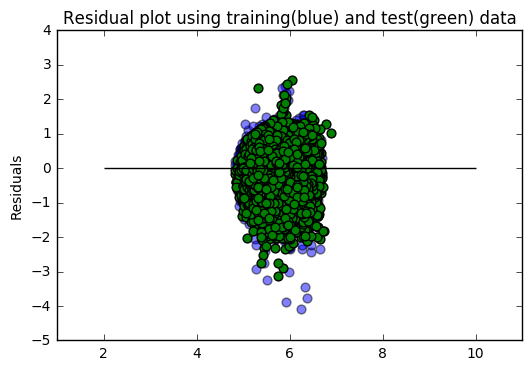

In [53]:
#pass train and test quarters
inputpath=str(os.getcwd())+"\\"+'input.csv'

reader=csv.reader(open(inputpath),delimiter=',')
data=[]
for row in reader:
    data.append(row)
train=data[0][0]
test=data[0][1]

FeatureSelectionTechniques(train)
LinearRegressionAnalysis(train,test)
RandomForestAnalysis(train,test)
KNNAnalysis(train,test)
NeuralNetworkAnalysis(train,test)
# used for what-if analysis
FinancialCrisisEconomicBoomCheck(train,test)